<a href="https://colab.research.google.com/github/Pedro-Gianini/EX4_GEOPY/blob/main/EX4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Execício M4 - Trabalhando com dados OSM,  análise de vizinhança e reclassificação de dados**

Agora vamos praticar e expandir o que aprendemos no módulo M4 - Trabalhando com dados OSM,  análise de vizinhança e reclassificação de dados.

O objetivo geral é definir áreas de dominância para 8 shopping centers em Helsinque com diferentes modos de viagem (transporte público, carro particular). O último passo é descobrir quantas pessoas vivem nas áreas de domínio desses grandes shopping centers na região de Helsinque.

**E1- Combinando dados de acessibilidade em um grid e criando visualizações**

Acesse [aqui](https://drive.google.com/drive/folders/1p25YEUx6pdb_VX3bNLYyLC54TIDDmmsa) um conjunto de dados que inclui 7 arquivos de texto contendo dados sobre acessibilidade na região de Helsinki e um Shapefile que contém uma grade de polígonos que pode ser usada para visualizar e analisar os dados espacialmente. 

Os conjuntos de dados são:
* travel_times_to_ [XXXXXXX] _ [NOME DO SHOPPING] .txt incluindo tempos de viagem e distâncias da rede rodoviária até um shopping center específico

* MetropAccess_YKR_grid_EurefFIN.shp incluindo a grade Polygon com coluna YKR_ID que pode ser usada para unir a grade com os dados de acessibilidade


a) Leia esses arquivos de dados travel_time (um por um) com a Pandas e selecione apenas as seguintes colunas :
* pt_r_tt  - tempo transporte público
* car_r_t - tempo de carro
* from_id - id da célula de origem
* to_id - id da célula de destino

In [1]:
# Atualiza a lista de pacotes instalados
!apt update -q
# Atualiza os pacotes para sua versão mais recente
!apt upgrade -q
# Instalando pacotes necessários
!apt install gdal-bin python-gdal python3-gdal -q
!apt install python3-rtree -q 
!pip install geopandas==0.10.0
!pip install descartes -q

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1,010 kB]
Hit:12 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,15

In [2]:
# Aqui montamos o acesso ao nosso Google drive, assim podemos salvar e acessar dados diretamente de lá
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
# Defina o caminho para a pasta onde estão os arquivos a serem lidos
camin='/content/drive/MyDrive/PYGEO/M4/E4'

# Importe o pacote os para manipular os caminhos para arquivos
import os

# Crie uma lista vazia para armazenar o nome dos arquivos
dados=[]

# Inicie um loop por todos os arquivos na pasta indicada pela variável camin
# os.listdir criará uma lista dos arquivos naquela pasta
for arquivo in os.listdir(camin):
  # Verifique se o nome do arquivo começa com 'TravelTimes_to'
  if arquivo.startswith('TravelTimes_to'):
    # Caso comece, adicione o nome do arquivo à lista dados
    dados.append(arquivo)
    
# Inspecione o resultado
dados

['TravelTimes_to_5878070_Jumbo.txt',
 'TravelTimes_to_5878087_Dixi.txt',
 'TravelTimes_to_5902043_Myyrmanni.txt',
 'TravelTimes_to_5944003_Itis.txt',
 'TravelTimes_to_5975373_Forum.txt',
 'TravelTimes_to_5978593_Iso_omena.txt',
 'TravelTimes_to_5980260_Ruoholahti.txt']

In [4]:
# Mude o diretório atual para a pasta onde estão os arquivos TravelTimes_to_XXXXXXX_XXXXX.txt
os.chdir(camin)

In [5]:
# Importe a biblioteca pandas para manipular tabelas
import pandas as pd

# Vamos ler o arquivo correspondente ao shopping de Ruoholahti, como
# ele é o último da lista dados usamos o índice -1 para acessá-lo. E o
# separador do txt é ; nesse caso
Ruoholahti=pd.read_csv(dados[-1], sep=';')
# Inpecione o resultado
Ruoholahti.head()

,from_id,to_id,walk_t,walk_d,car_r_t,car_r_d,car_m_t,car_m_d,pt_r_t,pt_r_tt,pt_r_d,pt_m_t,pt_m_tt,pt_m_d
0,5785640,5980260,468,32784,56,33768,49,33805,118,147,34474,125,156,34474
1,5785641,5980260,431,30168,56,33979,49,34016,121,142,34680,128,155,34680
2,5785642,5980260,432,30247,63,33380,56,31641,123,142,34797,130,156,34797
3,5785643,5980260,436,30540,67,35937,60,34198,127,153,35090,134,160,35090
4,5787544,5980260,461,32295,55,33342,48,33380,111,130,33984,118,135,33984


In [6]:
# Aqui selecionamos apenas as colunas de interesse
Ruoholahti=Ruoholahti[['pt_r_tt','car_r_t','from_id','to_id']]
# Inpecione o resultado
Ruoholahti.head()

,pt_r_tt,car_r_t,from_id,to_id
0,147,56,5785640,5980260
1,142,56,5785641,5980260
2,142,63,5785642,5980260
3,153,67,5785643,5980260
4,130,55,5787544,5980260


b) Visualize os tempos de viagem classificados (Transporte público e carro) de pelo menos um dos shoppings usando os métodos de classificação que aprendemos na aula.

In [7]:
# Importe a geopandas para manipular dados vetoriais
import geopandas as gpd

# Leia o grid de polígonos com as zona de transporte
grid=gpd.read_file('/content/drive/MyDrive/PYGEO/M4/E4/MetropAccess_YKR_grid_EurefFIN.shp')
# Inspecione o resultado
grid.head()

,x,y,YKR_ID,geometry
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6..."
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6..."
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6..."
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6..."


In [8]:
# Use um table join (merge) para combinar as geometrias do grid e as infromações
# sobre tempo de viagem do arquivo txt
tt_Ruoholahti=grid.merge(Ruoholahti,right_on='from_id',left_on='YKR_ID', how='inner')
# Inspecione o resultado
tt_Ruoholahti.head()

,x,y,YKR_ID,geometry,pt_r_tt,car_r_t,from_id,to_id
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",147,56,5785640,5980260
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",142,56,5785641,5980260
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",142,63,5785642,5980260
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",153,67,5785643,5980260
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",130,55,5787544,5980260


In [9]:
# Remova linhas com no data (-1), ou seja sem infromação sobre o tempo
# de viagem por transporte público
tt_Ruoholahti=tt_Ruoholahti[tt_Ruoholahti['pt_r_tt']>0]

In [10]:
# Instale e importe o mapclassify para visualizar os dados classificados
!pip install mapclassify==2.4.3 -q
import mapclassify

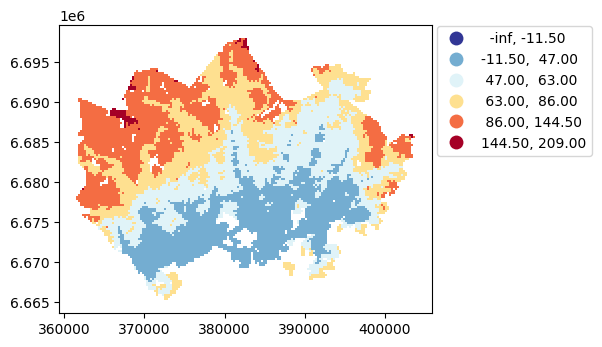

In [34]:
import matplotlib.pyplot as plt
# Visualize o tempo de viagem por transporte público
tt_Ruoholahti.plot(column="pt_r_tt", scheme="BoxPlot", k=5, cmap="RdYlBu_r", linewidth=0,legend=True, legend_kwds={'bbox_to_anchor': (1.150, 0.82, 0.3, 0.2)})
# Remova os espaços ao redor do plot
plt.tight_layout()

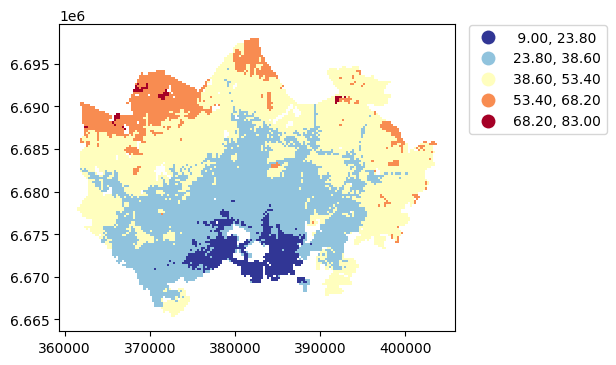

In [12]:
# Visualize o tempo de viagem de carro
tt_Ruoholahti.plot(column="car_r_t", scheme="EqualInterval", k=5, cmap="RdYlBu_r", linewidth=0,legend=True, legend_kwds={'bbox_to_anchor': (1.10, 0.82, 0.3, 0.2)})
# Remova os espaços ao redor do plot
plt.tight_layout()

**E2- Calcule e visualize as áreas de influência de cada shopping**

O objetivo é definir a área de influência para cada um desses shopping centers com base no tempo de viagem de carro.


a) Itere sobre os arquivos de acessibilidade um por um e renomeie as colunas de tempo de viagem para que possam ser identificadas para cada shopping

b) Junte essas as colunas que indicam o tempo de viagem para cada shopping ao shapefile em MetropAccess_YKR_grid_EurefFIN.shp onde YKR_ID na grade corresponde a from_id no arquivo de dados de tempo de viagem. No final você deve ter um GeoDataFrame com diferentes colunas mostrando os tempos de viagem para diferentes shopping centers.


In [13]:
# Importe a biblioteca re para manipular padrões em textos
import re
# Encontre a parte do texto (sequência de caracterers) que segue o padrão descrito
# entre aspas. [0-9] (números) seguidos de \_ (underscore) seguidos de  
# (.*?) quaisquer caracteres seguidos de ponto \. Como a função re.findall
# retorna uma lista, usamo o índice [0] para pegar o conteúdo dessa lista, seu
# primeiro elemento
print(re.findall(r"[0-9]\_(.*?)\.", dados[1])[0])

Dixi


In [14]:
# Copie o grid de polígonos
tt_all=grid
# Crie uma lista vazia para armazenar os nomes das colunas que indicam
# tempo de viagem por transporte público para os shoppings
pe_labs=[]
# Crie uma lista vazia para armazenar os nomes das colunas que indicam
# tempo de viagem de carro para os shoppings
car_labs=[]

# Inicie um loop pela lista de arquivos de texto com o tempo de viagem para
# cada um dos shoppings
for arquivo in dados:
    # Leia o arquivo sendo iterado 
    tv= pd.read_csv(arquivo,sep=';')
    # Remova as linhas com valores nulos (-1) de tempo de viagem
    tv=tv[tv['car_r_t']>0]
    tv=tv[tv['pt_r_tt']>0]
    # Use a expressão regular (regex) para extrair o nome do shopping do
    # nome do arquivo sendo iterado
    shopping=re.findall(r"[0-9]\_(.*?)\.", arquivo)[0]
    # Junte o nome do shopping ao sufixo _car para criar o nome da coluna 
    # que indica o tempo de viagem de carro para o shopping sendo iterado
    car_lab='%s_car'%(shopping)
    # Junte o nome do shopping ao sufixo _transporte para criar o nome da coluna 
    # que indica o tempo de viagem por transporte público para o shopping sendo iterado
    pe_lab='%s_transporte'%(shopping)
    # Renomeie as colunas com os nome criados acima
    tv=tv.rename(columns={'car_r_t':car_lab,'pt_r_tt':pe_lab})
    # Adicione o nome das colunas as listas vazias que criamos para armazenar
    # os nome das colunas que indicam os tempos de viagem de carro e por transporte
    # público
    pe_labs.append(pe_lab)
    car_labs.append(car_lab)
    # Use as listas para selecionar apenas as colunas  de interesse, ou seja,
    # as que indicam os tempos de viagem e a que permite juntar a tabela ao grid
    tv=tv[[car_lab,pe_lab,'from_id']]
    # Realize um table join entre a tabela com os tempos de viagem e o grid
    tt_all=tt_all.merge(tv,right_on='from_id',left_on='YKR_ID', how='inner')
    # Remova a coluna from_id para evitar colunas duplicadas
    del(tt_all['from_id'])

In [15]:
# Inspecione o nome da colunas que indicam o tempo de viagem de carro
car_labs

['Jumbo_car',
 'Dixi_car',
 'Myyrmanni_car',
 'Itis_car',
 'Forum_car',
 'Iso_omena_car',
 'Ruoholahti_car']

c) Para cada linha descubra o valor mínimo de todas as colunas XXX_car_r_tt e insira esse valor em uma nova coluna chamada min_car.


d) Para cada linha descubra o nome do shopping mais próximo e insira esse valor em uma nova coluna chamada influência.

In [16]:
# Crie uma coluna vazia para armazenar o menor tempo de viagem de carro 
tt_all['min_car']=None
# Crie uma coluna vazia para armazenar o nome do shopping que está ao alcance
# nesse tempo minímo de viagem
tt_all['influencia']=None

# Comece um loop para iterar sobre todas as linhas do nosso geodataframe
for index,row in tt_all.iterrows():
    # Para cada linha calcule o tempo minímo de carro, ou seja, o tempo para o
    # shopping mais próximo, e armazene o valor na coluna  vazia que criamos min_car
    tt_all.loc[index,'min_car']= (row[car_labs].min())
    # Crie um dataframe com os valores da linha sendo iterada. Aqui as linhas
    # serão o nome dos shoppings (que se tornarão o índice) e teremos uma
    # coluna indicando o tempo de viagem
    df=(pd.DataFrame(row[car_labs],))
    # Renomeie a  primeira coluna desse dataframe para tempo
    df.rename(columns={ df.columns[0]: "tempo" }, inplace = True)
    # Verifique qual das linhas do dataframe criado possuem o tempo de viagem minímo
    # e selecione o índice dessa linhas. Quebre o índice selecionado para obter apenas
    # o nome do shopping. Esse nome será armazenado na coluna influência
    tt_all.loc[index,'influencia']=(str.split(df.index[df.tempo == df.tempo.min()][0],'_car'))[0]

In [17]:
# Inspecione o resultado
tt_all.head()

,x,y,YKR_ID,geometry,Jumbo_car,Jumbo_transporte,Dixi_car,Dixi_transporte,Myyrmanni_car,Myyrmanni_transporte,Itis_car,Itis_transporte,Forum_car,Forum_transporte,Iso_omena_car,Iso_omena_transporte,Ruoholahti_car,Ruoholahti_transporte,min_car,influencia
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",39,131,45,134,39,121,50,157,49,137,56,166,56,147,39,Jumbo
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",39,129,45,130,39,115,51,154,49,134,56,164,56,142,39,Jumbo
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",45,129,52,130,47,115,58,154,57,134,64,164,63,142,45,Jumbo
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",46,138,48,140,51,126,57,163,60,144,67,174,67,153,46,Jumbo
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",38,115,44,118,38,103,50,142,48,121,55,150,55,130,38,Jumbo


e) Visualize os tempos de viagem da nossa coluna min_car usando um classificador


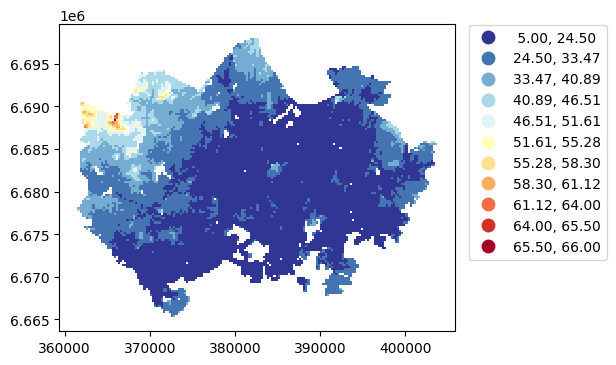

In [18]:
# Use a função  .plot da geopandas e especifique a coluna min_car
tt_all.plot(column="min_car", scheme="HeadTailBreaks", cmap="RdYlBu_r", linewidth=0,legend=True, legend_kwds={'bbox_to_anchor': (1.10, 0.82, 0.3, 0.2)})
plt.tight_layout()

f) Visualize também os valores na coluna influência

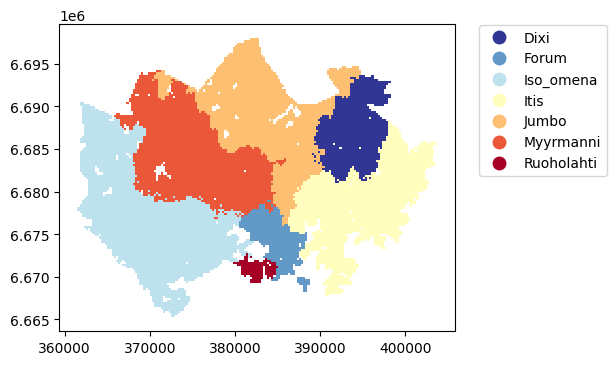

In [19]:
# Use a função plot da geopandas e não defina nenhum classificador, já que
# é um dado qualitativo
tt_all.plot(column="influencia", cmap="RdYlBu_r", linewidth=0,legend=True, legend_kwds={'bbox_to_anchor': (1.10, 0.82, 0.3, 0.2)})
plt.tight_layout()

**E3 - Quantas pessoas vivem na área de influência de cada shopping**

Os dados de população estão no shapefile Vaestotietoruudukko_2020.shp, a coluna asukaita  indica a população.

a) Leia os dados de população

In [20]:
# Use a função gpd.read_file para ler o shapefile que está na pasta e4 
# dados pygeo
pop20=gpd.read_file('/content/drive/MyDrive/PYGEO/M4/E4/Vaestotietoruudukko_2020.shp')
# Inspecione o resultado
pop20.head()

,INDEX,ASUKKAITA,ASVALJYYS,IKA0_9,IKA10_19,IKA20_29,IKA30_39,IKA40_49,IKA50_59,IKA60_69,IKA70_79,IKA_YLI80,geometry
0,703,5,51.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6685998.998, 25472499.9..."
1,710,8,44.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6684249.004, 25472499.9..."
2,711,5,90.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6683999.005, 25472499.9..."
3,715,13,34.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472499.995 6682998.998, 25472499.9..."
4,848,5,53.0,99,99,99,99,99,99,99,99,99,"POLYGON ((25472749.993 6690249.003, 25472749.9..."


b) Agregue as áreas de influência em geometrias unificadas usando a função [dissolve()](https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html)

In [21]:
# Use a função .dissolve para agregar os polígonos que são parte da mesma
# área de influência. Criando assim polígonos únicos de área de influência para
# cada um dos shoppings
area_influ=tt_all.dissolve(by='influencia')
# Verifique o número de linhas (polígonos) gerados pelo dissolve
print(area_influ.shape)

(7, 19)


In [22]:
# Verifique o número de linhas (polígonos) existente antes do dissolve
tt_all.shape

(13013, 20)

In [23]:
# Crie uma nova coluna para guardar os nome das áreas de influência que
# foram transformados em índice
area_influ['influencia']=area_influ.index
# Defina a coluna YKR_ID como índice
area_influ=area_influ.set_index('YKR_ID')

In [24]:
# Inspecione o resultado
area_influ.head()

,geometry,x,y,Jumbo_car,Jumbo_transporte,Dixi_car,Dixi_transporte,Myyrmanni_car,Myyrmanni_transporte,Itis_car,Itis_transporte,Forum_car,Forum_transporte,Iso_omena_car,Iso_omena_transporte,Ruoholahti_car,Ruoholahti_transporte,min_car,influencia
YKR_ID,,,,,,,,,,,,,,,,,,,
5818066,"MULTIPOLYGON (((390000.000 6683500.000, 390000...",394625.0,6693630.0,31,65,30,43,44,77,31,72,46,65,55,94,51,72,30,Dixi
5927648,"MULTIPOLYGON (((381250.000 6675500.000, 381000...",383875.0,6678880.0,27,43,32,42,24,30,28,42,23,31,34,58,30,41,23,Forum
5842489,"MULTIPOLYGON (((362250.000 6676000.000, 362500...",361875.0,6690380.0,65,143,73,129,62,108,71,142,66,116,57,108,65,118,57,Iso_omena
5855753,"MULTIPOLYGON (((388250.000 6673250.000, 388250...",395875.0,6688630.0,22,69,19,49,33,82,18,64,34,61,43,86,39,63,18,Itis
5785640,"MULTIPOLYGON (((375500.000 6690250.000, 375500...",381875.0,6697880.0,39,131,45,134,39,121,50,157,49,137,56,166,56,147,39,Jumbo


c) Performe uma junção espacial (spatial join) entre as áreas de influência e os dados de população

In [25]:
# Verifique se os dados estão no mesmo sistema de coordenadas
area_influ.crs==pop20.crs

False

In [26]:
# Verifique o sistema de coordendas das áreas de influência
area_influ.crs

<Projected CRS: EPSG:3067>
Name: ETRS89 / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland - onshore and offshore.
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [27]:
# Reprojete os dados de população para o mesmo sistema de coordenadas das
# áreas de influência
pop20=pop20.to_crs(crs=area_influ.crs)
# Verifique se os dados estão no mesmo sistema de coordenadas
area_influ.crs==pop20.crs

True

In [28]:
# Realize o spatial join entre as áreas de influência e os dados de população
# os grids de pop20 que estiverem dentro (within) da área de influência receberão
# os atributos da área de influência
pop_join=gpd.sjoin(pop20,area_influ, how='inner',predicate='within')
# Verifique o resultado
pop_join.head()

,INDEX,ASUKKAITA,ASVALJYYS,IKA0_9,IKA10_19,IKA20_29,IKA30_39,IKA40_49,IKA50_59,IKA60_69,...,Itis_car,Itis_transporte,Forum_car,Forum_transporte,Iso_omena_car,Iso_omena_transporte,Ruoholahti_car,Ruoholahti_transporte,min_car,influencia
0,703,5,51.0,99,99,99,99,99,99,99,...,71,142,66,116,57,108,65,118,57,Iso_omena
1,710,8,44.0,99,99,99,99,99,99,99,...,71,142,66,116,57,108,65,118,57,Iso_omena
2,711,5,90.0,99,99,99,99,99,99,99,...,71,142,66,116,57,108,65,118,57,Iso_omena
3,715,13,34.0,99,99,99,99,99,99,99,...,71,142,66,116,57,108,65,118,57,Iso_omena
5,864,11,61.0,99,99,99,99,99,99,99,...,71,142,66,116,57,108,65,118,57,Iso_omena


d) Agrupe os dados resultantes do spatial join por área de influência e obtenha a soma da população na área de cada shopping

In [29]:
# Agrupe os dados resultantes do spatial join com base em sua área de influência 
# e compute a soma da população (ASUKKAITA) por área de influência
pop=pop_join.groupby('influencia')[['ASUKKAITA']].sum()
# Crie uma nova coluna para guardar os nome das áreas de influência que
# foram transformados em índice
pop['influ']=pop.index
# Crie uma nova coluna com valores de índice
pop['index']=[0,1,2,3,4,5,6]
# Defina a nova coluna como índice do geodataframe
pop=pop.set_index('index')
# Verifique o resultado
pop.head()

,ASUKKAITA,influ
index,,
0,123764,Dixi
1,189674,Forum
2,225579,Iso_omena
3,258313,Itis
4,94018,Jumbo


e) Performe um table join entre os dados do agrupamento em d e as geometrias das áreas de influência

In [30]:
# Use a função merge para combinar os dados de população total por árae de influência
# com as geometrias das áreas de influência dos shoppings
pop_shop= area_influ.merge(pop, left_on='influencia', right_on='influ', how='left')
# Inspecione o resultado
pop_shop.head()

,geometry,x,y,Jumbo_car,Jumbo_transporte,Dixi_car,Dixi_transporte,Myyrmanni_car,Myyrmanni_transporte,Itis_car,...,Forum_car,Forum_transporte,Iso_omena_car,Iso_omena_transporte,Ruoholahti_car,Ruoholahti_transporte,min_car,influencia,ASUKKAITA,influ
0,"MULTIPOLYGON (((390000.000 6683500.000, 390000...",394625.0,6693630.0,31,65,30,43,44,77,31,...,46,65,55,94,51,72,30,Dixi,123764,Dixi
1,"MULTIPOLYGON (((381250.000 6675500.000, 381000...",383875.0,6678880.0,27,43,32,42,24,30,28,...,23,31,34,58,30,41,23,Forum,189674,Forum
2,"MULTIPOLYGON (((362250.000 6676000.000, 362500...",361875.0,6690380.0,65,143,73,129,62,108,71,...,66,116,57,108,65,118,57,Iso_omena,225579,Iso_omena
3,"MULTIPOLYGON (((388250.000 6673250.000, 388250...",395875.0,6688630.0,22,69,19,49,33,82,18,...,34,61,43,86,39,63,18,Itis,258313,Itis
4,"MULTIPOLYGON (((375500.000 6690250.000, 375500...",381875.0,6697880.0,39,131,45,134,39,121,50,...,49,137,56,166,56,147,39,Jumbo,94018,Jumbo


f) Visualize o resultado usando um classificador e um mapa base


In [31]:
# Instale e importe a biblioteca contextily para utilizar seus mapas base
!pip install contextily -q
import contextily as cx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 91.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


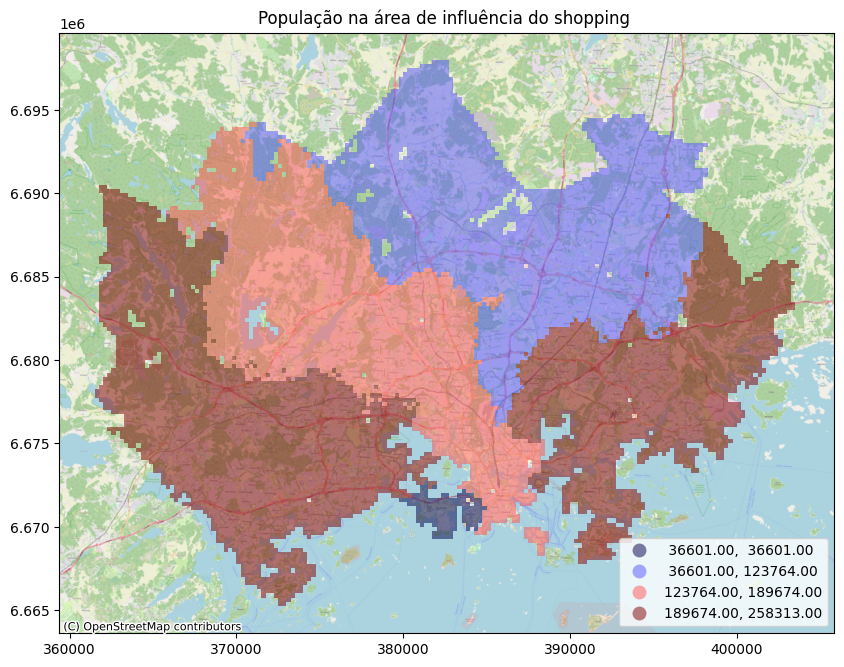

In [32]:
# Crie a figura, eixo de plotagem e defina o tamanho da figura
fig,ax= plt.subplots(figsize=(10,10))
# Plote no eixo de plotagem criado acima. Use os dados da coluna ASUKKAITA (população) com 4 classes e classificação por quebras naturais
pop_shop.plot(ax=ax, cmap='seismic', column='ASUKKAITA', scheme='natural_breaks', k=4,legend=True, alpha=0.5,legend_kwds={'loc': 'lower right'})
# Adicione o título
plt.title('População na área de influência do shopping ')
# Acrescente o mapa base de fundo
cx.add_basemap(ax=ax, crs=pop_shop.crs, zoom=13, source =  cx.providers.OpenStreetMap.Mapnik)